In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'input/stage1_train/'
TEST_PATH = 'input/stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [10]:
# Get train data
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [11]:
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

for n, id_ in enumerate(train_ids):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

In [4]:
print(X_train.shape)
print(Y_train.shape)

(600, 128, 128, 3)
(600, 128, 128, 1)


In [5]:
# Get test data
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
sizes_test = []

for n, id_ in enumerate(test_ids):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_test[n] = mask    
#print(X_test.shape)

In [6]:
print(X_test.shape)
print(Y_test.shape)

(70, 128, 128, 3)
(70, 128, 128, 1)


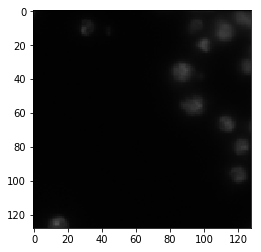

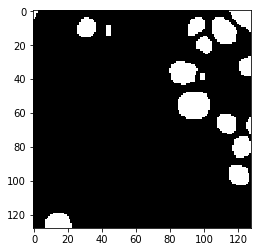

In [7]:
import random

# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(X_train[ix])
plt.show()
plt.imshow(np.squeeze(Y_train[ix]), 'gray')
plt.show()

In [8]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [12]:
from keras.models import *
from keras.layers import Input, merge, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Dropout, Cropping2D, BatchNormalization
from keras.optimizers import *
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import Lambda

def setMyUnet():
        inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
        s = Lambda(lambda x: x / 255) (inputs)

        c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
        c1 = BatchNormalization()(c1)
        c1 = Dropout(0.1) (c1)
        c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
        c1 = BatchNormalization()(c1)
        p1 = MaxPooling2D((2, 2)) (c1)

        c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
        c2 = BatchNormalization()(c2)
        c2 = Dropout(0.2) (c2)
        c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
        c2 = BatchNormalization()(c2)
        p2 = MaxPooling2D((2, 2)) (c2)

        c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
        c3 = BatchNormalization()(c3)
        c3 = Dropout(0.2) (c3)
        c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
        c3 = BatchNormalization()(c3)
        p3 = MaxPooling2D((2, 2)) (c3)

        c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
        c4 = BatchNormalization()(c4)
        c4 = Dropout(0.2) (c4)
        c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
        c4 = BatchNormalization()(c4)
        p4 = MaxPooling2D((2, 2)) (c4)
        
        c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
        c5 = BatchNormalization()(c5)
        c5 = Dropout(0.2) (c5)
        c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)
        c5 = BatchNormalization()(c5)
        p5 = MaxPooling2D((2, 2)) (c5)

        c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (p1)
        c6 = BatchNormalization()(c6)
        c6 = Dropout(0.3) (c6)
        c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (c6)
        c6 = BatchNormalization()(c6)
        
        u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
        #u7 = concatenate([u6, c4])
        c7 = Conv2D(128, (3, 3), activation='relu', padding='same') (u7)
        c7 = BatchNormalization()(c7)
        c7 = Dropout(0.2) (c7)
        c7 = Conv2D(128, (3, 3), activation='relu', padding='same') (c7)
        c7 = BatchNormalization()(c7)

        u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
        #u8 = concatenate([u8, c4])
        c8 = Conv2D(64, (3, 3), activation='relu', padding='same') (u8)
        c8 = BatchNormalization()(c8)
        c8 = Dropout(0.2) (c8)
        c8 = Conv2D(64, (3, 3), activation='relu', padding='same') (c8)
        c8 = BatchNormalization()(c8)
        
        u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
        #u9 = concatenate([u9, c3])
        c9 = Conv2D(32, (3, 3), activation='relu', padding='same') (u9)
        c9 = BatchNormalization()(c9)
        c9 = Dropout(0.2) (c9)
        c9 = Conv2D(32, (3, 3), activation='relu', padding='same') (c9)
        c9 = BatchNormalization()(c9)

        u10 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c6)
        #u10 = concatenate([u10, c2], axis=3)
        c10 = Conv2D(16, (3, 3), activation='relu', padding='same') (u10)
        c10 = BatchNormalization()(c10)
        c10 = Dropout(0.1) (c10)
        c10 = Conv2D(16, (3, 3), activation='relu', padding='same') (c10)
        c10 = BatchNormalization()(c10)
        
        u11 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c6)
        #u11 = concatenate([u11, c1], axis=3)
        c11 = Conv2D(8, (3, 3), activation='relu', padding='same') (u11)
        c11 = BatchNormalization()(c11)
        c11 = Dropout(0.1) (c11)
        c11 = Conv2D(8, (3, 3), activation='relu', padding='same') (c11)
        c11 = BatchNormalization()(c11)
        
        outputs = Conv2D(1, (1, 1), activation='sigmoid') (c11)
        
        
        model = Model(inputs=[inputs], outputs=[outputs])

        model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=[mean_iou])
        
        return model

In [13]:
model = setMyUnet()
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       224       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 8)       32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 8)       584       
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 8)       32        
__________

In [14]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

batch_size = 8
epochs = 50

# Fit model
#earlystopper = EarlyStopping(patience=20, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1-FCN-3.h5', verbose=1, save_best_only=True)
history_ft = model.fit(
            X_train,
            Y_train,
            validation_split=0.1,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[checkpointer])


Train on 540 samples, validate on 60 samples
Epoch 1/50
540/540 [==============================] - 11s 20ms/step - loss: 0.5232 - mean_iou: 0.5607 - val_loss: 0.3258 - val_mean_iou: 0.6380

Epoch 00001: val_loss improved from inf to 0.32578, saving model to model-dsbowl2018-1-FCN-3.h5
Epoch 2/50
540/540 [==============================] - 6s 12ms/step - loss: 0.3361 - mean_iou: 0.6708 - val_loss: 0.2456 - val_mean_iou: 0.6931

Epoch 00002: val_loss improved from 0.32578 to 0.24555, saving model to model-dsbowl2018-1-FCN-3.h5
Epoch 3/50
540/540 [==============================] - 6s 11ms/step - loss: 0.2420 - mean_iou: 0.7129 - val_loss: 0.1549 - val_mean_iou: 0.7277

Epoch 00003: val_loss improved from 0.24555 to 0.15492, saving model to model-dsbowl2018-1-FCN-3.h5
Epoch 4/50
540/540 [==============================] - 6s 11ms/step - loss: 0.1933 - mean_iou: 0.7390 - val_loss: 0.1532 - val_mean_iou: 0.7486

Epoch 00004: val_loss improved from 0.15492 to 0.15325, saving model to model-dsbo

In [15]:
def plot_training(history):
  loss = history.history['loss']
  mean_iou = history.history['mean_iou']
  val_loss = history.history['val_loss']
  val_mean_iou = history.history['val_mean_iou']
  
  epochs = range(len(loss))
  history = {'loss':loss,'mean_iou':mean_iou,'val_loss':val_loss,'val_mean_iou':val_mean_iou}
  np.save('history-FCN-3.npy',history)
  #a=np.load('history-unet.npy').item()
  plt.plot(epochs, mean_iou, 'b.')
  plt.plot(epochs, val_mean_iou, 'r')
  plt.title('Training and validation iou')
  
  plt.figure()
  plt.plot(epochs, loss, 'b.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')

  plt.show()

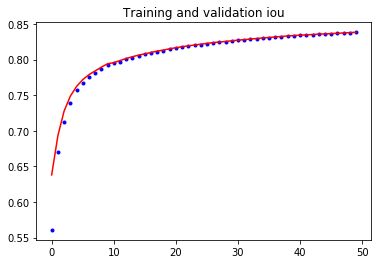

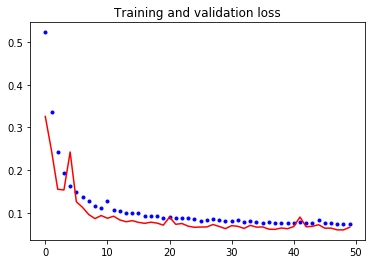

In [16]:
plot_training(history_ft)
#print(history_ft.history['loss'])

In [17]:
score, acc = model.evaluate(X_test, Y_test,
                            batch_size=batch_size)

print(score,acc)

70/70 [==============================] - 1s 10ms/step
0.07565094158053398 0.8385220561708723


In [18]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1-FCN-3.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks  
# preds_test_upsampled = []
# for i in range(len(preds_test)):
#     preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
#                                        (sizes_test[i][0], sizes_test[i][1]), 
#                                        mode='constant', preserve_range=True))

70/70 [==============================] - 0s 3ms/step


/home/rameshkonatala/anaconda3/envs/env/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/rameshkonatala/anaconda3/envs/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


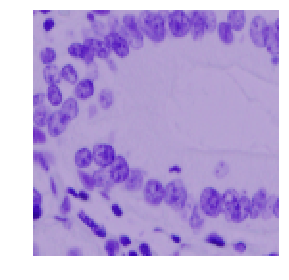

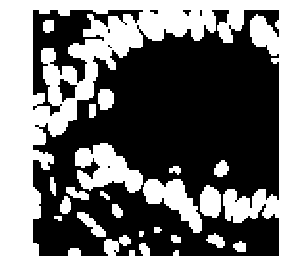

/home/rameshkonatala/anaconda3/envs/env/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


(0.0, 1.0, 0.0, 1.0)

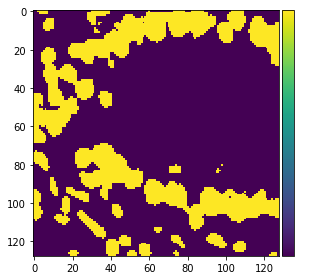

In [19]:
# Perform a sanity check on some random validation samples
#ix = random.randint(0, len(preds_val_t))
ix=1

plt.show()
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.axis('off')

plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.axis('off')

plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.axis('off')


/home/rameshkonatala/anaconda3/envs/env/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/rameshkonatala/anaconda3/envs/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


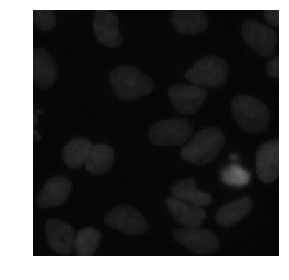

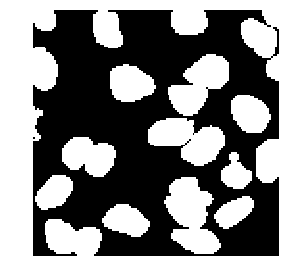

/home/rameshkonatala/anaconda3/envs/env/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


(0.0, 1.0, 0.0, 1.0)

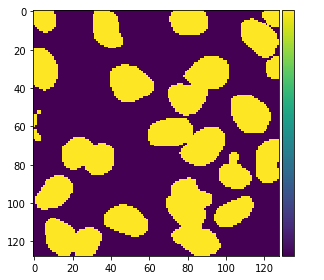

In [20]:
ix=16
plt.show()
imshow(X_test[ix])
plt.axis('off')

plt.show()
imshow(np.squeeze(Y_test[ix]))
plt.axis('off')

plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.axis('off')